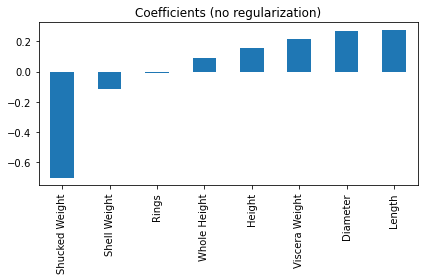

Training Score 0.4522502744237102
Testing Score 0.4523281596452328
 Ridge-regularized Training Score 0.4510451045104511
Ridge-regularized Testing Score 0.4488888888888889


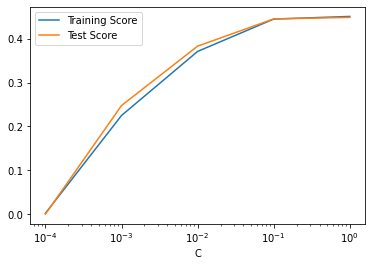

{'C': 0.01} 0.3515164520219558
0.3832923832923833
Best C value [17.07352647]
Best fit coefficients [[ 0.15043655  0.39239558  0.13216993  0.01841241 -0.64730744  0.22002801
  -0.0789581  -0.00069608]]


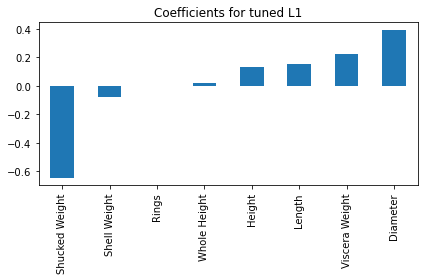

<Figure size 432x288 with 0 Axes>

In [1]:
# Multivariate classification using Abolone data from UCI ML repository
# Goal is to predict sex from physical measurements excluding infants
# https://archive.ics.uci.edu/ml/datasets.php?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file='abalone.data'

#load and label data
df=pd.read_csv(file,header=None).rename(columns={
    0: 'Sex', 
    1: 'Length', 
    2: 'Diameter', 
    3: 'Height',
    4: 'Whole Height',
    5: 'Shucked Weight',
    6: 'Viscera Weight',
    7: 'Shell Weight',
    8: 'Rings'})

# remove infants (have indeterminant sex) from data set
df = df[df['Sex']!='I']

# discretize the sex where female = 1 and male = 0
sex_dict = {'F':1, 'M':0}
df['Sex_discretized'] = df['Sex'].map(sex_dict)

# set age as target (y) variable
y = df['Sex_discretized']

# Remove sex (not a measurement) and create a 'blind' feature set
features = df.drop(columns=['Sex', 'Sex_discretized'])

# feature engineering steps
# normalize and scale variances to achieve unbiased feature consideration
from sklearn.preprocessing import StandardScaler
standard_scaler_fit = StandardScaler().fit(features)
X = standard_scaler_fit.transform(features)

# Train-test split (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Fit a logistic regression classifier without regularization
from sklearn.linear_model import LogisticRegression

clf_no_reg = LogisticRegression(penalty = 'none') #(Remember to set the penalty parameter to 'none'!)
clf_no_reg.fit(X_train, y_train)

# Plot the coefficients
predictors = features.columns
coefficients = clf_no_reg.coef_.ravel()
coef = pd.Series(coefficients,predictors).sort_values()
coef.plot(kind='bar', title = 'Coefficients (no regularization)')
plt.tight_layout()
plt.show()
plt.clf()

# Training and test performance
from sklearn.metrics import f1_score
y_pred_test = clf_no_reg.predict(X_test)
y_pred_train = clf_no_reg.predict(X_train)
print('Training Score', f1_score(y_train, y_pred_train))
print('Testing Score', f1_score(y_test, y_pred_test))

# Default Implementation (L2-regularized!)
clf_default = LogisticRegression()
clf_default.fit(X_train, y_train)

# Ridge Scores
y_pred_train_ridge = clf_default.predict(X_train)
y_pred_test_ridge = clf_default.predict(X_test)
print(' Ridge-regularized Training Score', f1_score(y_train, y_pred_train_ridge))
print('Ridge-regularized Testing Score', f1_score(y_test, y_pred_test_ridge))

# Coarse-grained hyperparameter tuning
training_array = []
test_array = []
C_array = [0.0001, 0.001, 0.01, 0.1, 1]
for x in C_array:
    clf = LogisticRegression(C = x )
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    training_array.append(f1_score(y_train, y_pred_train))
    test_array.append(f1_score(y_test, y_pred_test))


# Plot training and test scores as a function of C
plt.plot(C_array,training_array, label = 'Training Score')
plt.plot(C_array,test_array, label = 'Test Score')
plt.xscale('log')
plt.xlabel('C')
plt.legend()
plt.show()
plt.clf()

# Making a parameter grid for GridSearchCV
C_array  = np.logspace(-4, -2, 100)
#Making a dict to enter as an input to param_grid
tuning_C = {'C':C_array}

# Implementing GridSearchCV with l2 penalty
from sklearn.model_selection import GridSearchCV
clf_gs = LogisticRegression()
gs = GridSearchCV(clf_gs, param_grid = tuning_C, scoring = 'f1', cv = 5)
gs.fit(X_train,y_train)

# Optimal C value and the score corresponding to it
print(gs.best_params_, gs.best_score_)

# Validating the "best classifier"
clf_best = LogisticRegression(C = gs.best_params_['C'])
clf_best.fit(X_train,y_train)
y_pred_best = clf_best.predict(X_test)
print(f1_score(y_test,y_pred_best))

# Implement L1 hyperparameter tuning with LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV
C_array = np.logspace(-2,2,100)
clf_l1 = LogisticRegressionCV(Cs=C_array, cv = 5, penalty = 'l1', scoring = 'f1', solver = 'liblinear')
clf_l1.fit(X,y)

# Optimal C value and corresponding coefficients
print('Best C value', clf_l1.C_)
print('Best fit coefficients', clf_l1.coef_)


# Plotting the tuned L1 coefficients
coefficients = clf_l1.coef_.ravel()
coef = pd.Series(coefficients,predictors).sort_values()
coef.plot(kind='bar', title = 'Coefficients for tuned L1')
plt.tight_layout()
plt.show()
plt.clf()